## Linear classifiers

В данном домашнем задании вы будете решать задачу классификации отзывов.

Шаги решения:

1. Извлечение признаков: напишите код для создания TF-IDF матрицы из представленного корпуса отзывов
2. Обучение моделей: напишите код для обучения SVM и логистической регрессии
3. Кросс-валидация для подбора гиперпараметров: напишите код для оптимизации метрик обучения
4. Участие в контесте на kaggle.com

In [1]:
import time
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report
from linear_svm import svm_loss_naive, svm_loss_vectorized
from gradient_check import grad_check_sparse
from linear_classifier import LinearSVM, Softmax
from softmax import softmax_loss_naive, softmax_loss_vectorized


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

-------
#### Знакомство с данными

In [22]:
data = pd.read_csv('kaggle_data/train.csv', index_col=0, na_values='NaN')
test_data = pd.read_csv('kaggle_data/test.csv', index_col=0, na_values='NaN')
print(data.shape)
print(data.head())
print(test_data.head())

(352278, 2)
                                                  summary  score
id                                                              
230872                                  Babies love these      3
344823                                       Salmon Trout      0
211754                                     disappointment      1
259421  Doesn't taste like Cinnabon; tastes like Waffl...      2
253418  Delicious San Daniele prosciutto and good cust...      3
                                  summary
id                                       
365507                    CHECK THE SUGAR
401398                      Great Product
45480                   This stuff rocks!
396287                   community coffee
44193   Not my favorite but good for you!


In [23]:
documents = data.summary.values
score = data.score.values
print("Score:\n  max:{}\n  min:{}".format(max(score), min(score)))
print("Docs:\n  " + "\n  ".join(documents[:10]))
test_docs = test_data.summary.values

Score:
  max:3
  min:0
Docs:
  Babies love these
  Salmon Trout
  disappointment
  Doesn't taste like Cinnabon; tastes like Waffle Crisp
  Delicious San Daniele prosciutto and good customer service
  My Dog Loves Them
  My husband's new favorite coffee.
  Good Job, Betty Crocker
  Good chips, more cheese
  Nature's Hallow Sugar Free Jam


Как видно, каждый объект представляет собой отзыв о продукте и оценку по шкале от 0 до 3. Выдвинем гипотезу, что слова, используемые в написании отзыва коррелируют с оценкой, которая была поставлена. Поставим задачу - предсказать оценку по тексту отзыва.

-----
###  Извлечение признаков

Для решения задачи классификации необходимо преобразовать каждый отзыв (документ) в вектор. Размерность данного вектора будет равна количеству слов используемых в корпусе (все документы). Каждая координата соответствует слову, значение в координает равно количеству раз, слово используется в документе.

В итоге получится матрица, в (i,j) ячейке которой написано количество раз, которое j-e слово встречается в i-ом документе. Заметим, что у такой матрицы получаются сильно разреженные строки(с большим количеством нулей).

Для учета важности редких, но показательных слов (термов), используется схема взвешивания TF-IDF. Преобразуем матрицу частот в матрицу документов, частоты термов которых взвешенны по TF-IDF.

Это преобразование можно делать сразу из набора документов с помощью TfidfVectorizer или сначала посчитать матрицу 
частот с помощью CountVectorizer, а потом преобразовать ее с помощью TfidfTransformer (как изначально было предложено в задании).

Используя TfidfVectorizer:

In [4]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

Используя CountVectorizer + TfidfTransformer:

In [5]:
count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform(documents)

In [6]:
tfidf_transformer = TfidfTransformer()
tfidf_matrix2 = tfidf_transformer.fit_transform(count_matrix)

Видно, что результат одинаков:

In [7]:
print(tfidf_matrix - tfidf_matrix2)

Но работать приятнее все-таки с TfidfVectorizer :)

Далее нам придется преобразовать полученную матрицу в numpy array и выполнять его преобразования, поэтому, чтобы python kernel не умирал, сократим максимальное количество слов-признаков каждого документа до 3000.

In [24]:
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
tfidf_matrix_test = tfidf_vectorizer.fit_transform(test_docs)

Преобразуем теперь полученную csr матрицу в numpy array:

In [25]:
tfidf_matrix = tfidf_matrix.toarray()
tfidf_matrix_test = tfidf_matrix_test.toarray()

------

### 2. Код для SVM и логистической регресии - 40 Баллов

После того, как вы получили матрицу признаков, вам необходимо реализовать алгоритм обучения SVM и логистической регрессии. Обе модели являются линейными и отличаются функциями потерь. Для решения оптимизационных задач в обеих моделях будет использоваться стохастический градиентный спуск.

Дополнительная информация для решения задачи:

- Линейные модели: http://cs231n.github.io/linear-classify/
- SGD: http://cs231n.github.io/optimization-1

Начнем с SVM стартовый код находится в файле cs231n/classifiers/linear_svm.py вашей задачей является реализация подсчета функции потерь для SVM

Разбейте обучающую выборку на 2 части train и test

Дополнительная информация для решения задачи:
- Используйте трансформер: http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html#sklearn.cross_validation.train_test_split

Транспонируем матрицы с данными, т.к. так будет проще реализовать код SVM

In [26]:
X_train = tfidf_matrix.transpose()
X_test = tfidf_matrix_test.transpose()
y_train = score

Возьмем подвыборки из обучающей выборки, для быстрой проверки кода.

In [27]:
X_train_sample = X_train[:, 0:100000]
X_test_sample = X_test[:,0:100000]
y_train_sample = y_train[0:100000]
# bias trick:
# temp = np.ones((X_train_sample.shape[0] + 1,X_train_sample.shape[1]))
# temp[:-1,:] = X_train_sample
 #X_train_sample = temp

Найдем чему равен градиент:

In [14]:
# generate a random SVM weight matrix of small numbers
W = np.random.randn(4, X_train_sample.shape[0]) * 0.01 
% time loss, grad = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
print('loss: {}\n gradient:{}'.format(loss, grad))

CPU times: user 3.68 s, sys: 33.3 ms, total: 3.71 s
Wall time: 3.05 s
loss: 2.997770938959977
 gradient:[[ -1.62685676e-05   2.88321488e-04   2.86588563e-04 ...,   9.25819244e-05
    2.27019372e-04   2.17639355e-04]
 [  5.60598785e-05   4.42504204e-04   3.21645020e-04 ...,   6.50117316e-05
    1.86173260e-04   2.17209357e-04]
 [  8.12785864e-06   1.17866797e-04   1.31494347e-04 ...,  -8.50893055e-06
    2.27265499e-04   1.16593317e-04]
 [ -4.77125456e-05  -8.48662167e-04  -7.40105980e-04 ...,  -1.49239596e-04
   -6.41009765e-04  -5.52112166e-04]]


Градиент равен 0, т.к. код который должен его считать отсутствует. Реализуйте наивную версию и проверьте результат с помощью численного метода расчета. Градиенты должны почти совпадать.

In [15]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_train_sample, y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 5)

numerical: -0.000107 analytic: -0.000107, relative error: 2.917289e-07
numerical: 0.001860 analytic: 0.001860, relative error: 1.164695e-08
numerical: 0.000094 analytic: 0.000094, relative error: 3.152034e-07
numerical: 0.000107 analytic: 0.000107, relative error: 3.306962e-07
numerical: 0.000023 analytic: 0.000023, relative error: 7.552477e-08


Теперь реализуйте векторизованную версию расчета фунции потерь - svm_loss_vectorized

In [16]:
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 2.997771e+00 computed in 3.213050s
Vectorized loss: 2.997771e+00 computed in 0.566610s
difference: -0.000000


Завершите реализацию SVM, реализуйте векторизированную версию расчета градиента.

In [17]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 3.269093s
Vectorized loss and gradient: computed in 0.492997s
difference: 0.000000


### Stochastic Gradient Descent

In [18]:
# Now implement SGD in LinearSVM.train() function and run it with the code below
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=5e-2, lambda_=0.01,
                      num_iters=500, verbose=True, batch_size=20000)

toc = time.time()
print('That took %fs' % (toc - tic))
print('Current loss is %f' % loss_hist[-1])

iteration 0 / 500: loss 2.999940
iteration 100 / 500: loss 2.645103
iteration 200 / 500: loss 2.367769
iteration 300 / 500: loss 2.222464
iteration 400 / 500: loss 2.138256
That took 356.467887s
Current loss is 2.107570


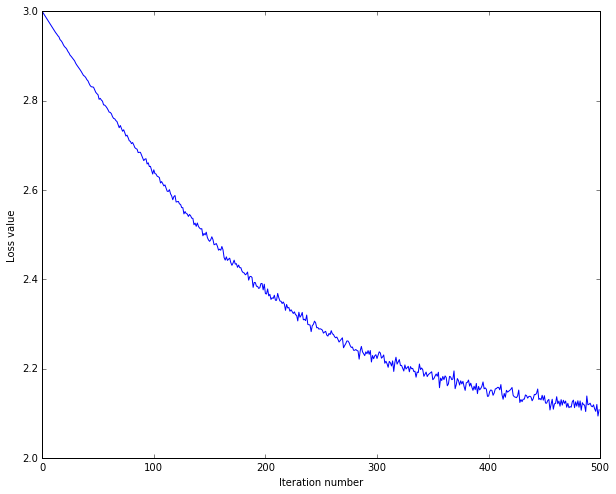

In [19]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [28]:
# Write the LinearSVM.predict function 
y_train_pred = svm.predict(X_train)
# y_test_pred = svm.predict(X_test)

In [161]:
#and evaluate the performance on both the test set

In [30]:
print(classification_report(y_train, y_train_pred))

             precision    recall  f1-score   support

          0       0.46      0.23      0.30     35097
          1       0.62      0.02      0.04     20066
          2       0.43      0.01      0.02     53979
          3       0.71      0.98      0.83    243136

avg / total       0.64      0.70      0.61    352278



In [33]:
# compare result with the most common dummy classifier
print(classification_report(y_train, [3]*len(y_train)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00     35097
          1       0.00      0.00      0.00     20066
          2       0.00      0.00      0.00     53979
          3       0.69      1.00      0.82    243136

avg / total       0.48      0.69      0.56    352278



/Users/nastya/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------

## Softmax Classifier

In [34]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(4, X_train_sample.shape[0]) * 0.01 
loss, grad = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.596507
sanity check: 2.302585


In [165]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
f = lambda w: softmax_loss_naive(w, X_train_sample, y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 5)

numerical: 0.000008 analytic: 0.000008, relative error: 2.102112e-07
numerical: -0.000015 analytic: -0.000015, relative error: 1.115073e-06
numerical: 0.000004 analytic: 0.000004, relative error: 1.951983e-07
numerical: -0.000035 analytic: -0.000035, relative error: 9.769634e-08
numerical: 0.000101 analytic: 0.000101, relative error: 2.062913e-07


In [166]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 1.386994e+00 computed in 6.640193s
vectorized loss: 1.386994e+00 computed in 0.427882s
Loss difference: 0.000000
Gradient difference: 0.000000


In [167]:
sm = Softmax()
tic = time.time()
loss_hist = sm.train(X_train, y_train, learning_rate=5e-2, reg=0.01,
                      num_iters=500, verbose=True, batch_size=20000)

toc = time.time()
print 'That took %fs' % (toc - tic)
print 'Current loss is %f' % loss_hist[-1]

iteration 0 / 500: loss 1.386299
iteration 100 / 500: loss 1.363543
iteration 200 / 500: loss 1.343818
iteration 300 / 500: loss 1.325619
iteration 400 / 500: loss 1.309761
That took 273.411873s
Current loss is 1.296077


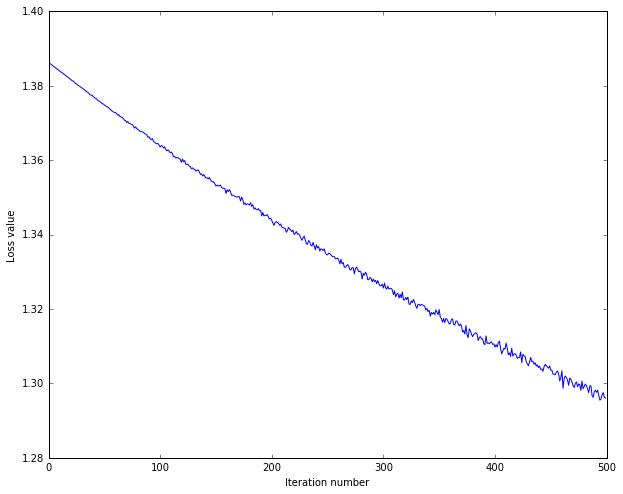

In [168]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [170]:
# Write the LinearSVM.predict function 
y_train_pred = sm.predict(X_train)
y_test_pred = sm.predict(X_test)

In [171]:
print classification_report(y_test, y_test_pred)

             precision    recall  f1-score   support

          0       0.52      0.20      0.29     15609
          1       0.13      0.03      0.05      8811
          2       0.25      0.02      0.04     24281
          3       0.71      0.97      0.82    109036

avg / total       0.59      0.69      0.60    157737



In [172]:
# compare result with the most common dummy classifier
print classification_report(y_test, [3]*len(y_test))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00     15609
          1       0.00      0.00      0.00      8811
          2       0.00      0.00      0.00     24281
          3       0.69      1.00      0.82    109036

avg / total       0.48      0.69      0.57    157737



------

### 3. Kaggle In Class - 50 Баллов

Используйте полученные модели для решения контеста. Выберете одну из моделей, реализуйте настройку гиперпараметров и пайплайн для предсказания классов тестовой выборки для сабмита в систему.

------

### 4. Бонусы - 30 Баллов

Улучшите результат: 

- Нормализуйте слова в документах, используйте стоп слова, попробуйте различные стратегии нормализации в TF-IDF
- Используйте PCA, Word2Vec для расширения пространства фичей
- Придумайте другие стратегии и улучшайте свой результат